In [1]:
%load_ext autoreload

In [2]:
%autoreload 2
from copy import deepcopy
from delase import DeLASE
from delase.metrics import mase
from hydra import compose, initialize
from matplotlib import font_manager
from matplotlib.colors import Normalize
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from scipy.stats import mannwhitneyu
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.manifold import MDS
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.model_selection import StratifiedKFold
import sys
from tqdm.auto import tqdm

sys.path.append('../..')
from data_utils import get_delase_results, get_delase_run_list, get_grid_search_results, get_grid_search_run_list, get_grid_search_window_ts, get_section_info, load_session_data, load_window_from_chunks

plt.style.use('/om2/user/eisenaj/code/UniversalUnconsciousness/sci_style.mplstyle')
font_path = "/om2/user/eisenaj/miniforge3/envs/communication-transformer/fonts/arial.ttf"
font_manager.fontManager.addfont(font_path)
prop = font_manager.FontProperties(fname=font_path)

In [3]:
with initialize(version_base="1.3", config_path="../../DeLASE_analysis/conf"):
    cfg = compose(config_name="config")

In [4]:
# data_class = cfg.params.data_class
session_list = [f[:-4] for f in os.listdir(os.path.join(cfg.params.all_data_dir, cfg.params.data_class)) if f.endswith('.mat')]
session_list = [session for session in session_list if session not in ['PEDRI_Ketamine_20220203']]

# session_list = [session_list[1]]
# session_list = [session_list[2]]
# session_list = ['SPOCK_Ketamine_20210712', 'PEDRI_Ketamine_20220106']
# session_list = ['PEDRI_Ketamine_20220106']
# session_list = ['PEDRI_Ketamine_20220203']
# session_list = ['PEDRI_Ketamine_20220113']

In [22]:
session_list

['SPOCK_Ketamine_20210802',
 'PEDRI_Ketamine_20220224',
 'PEDRI_Ketamine_20220228',
 'SPOCK_Ketamine_20210907',
 'SPOCK_Ketamine_20210826',
 'PEDRI_Ketamine_20220126',
 'SPOCK_Ketamine_20210707',
 'PEDRI_Ketamine_20220211',
 'PEDRI_Ketamine_20220425',
 'PEDRI_Ketamine_20220209',
 'PEDRI_Ketamine_20220217',
 'SPOCK_Ketamine_20210715',
 'PEDRI_Ketamine_20220215',
 'PEDRI_Ketamine_20220201',
 'PEDRI_Ketamine_20220128',
 'PEDRI_Ketamine_20220111',
 'PEDRI_Ketamine_20220222',
 'SPOCK_Ketamine_20210909',
 'PEDRI_Ketamine_20220124',
 'SPOCK_Ketamine_20210727',
 'SPOCK_Ketamine_20210719',
 'SPOCK_Ketamine_20210831',
 'PEDRI_Ketamine_20220106',
 'SPOCK_Ketamine_20210712',
 'SPOCK_Ketamine_20210730',
 'SPOCK_Ketamine_20210827',
 'SPOCK_Ketamine_20210902',
 'SPOCK_Ketamine_20210804',
 'PEDRI_Ketamine_20220113',
 'SPOCK_Ketamine_20210722']

In [23]:
session = 'PEDRI_Ketamine_20220209'

In [38]:
session_vars, T, N, dt = load_session_data(session, cfg.params.all_data_dir, ['sessionInfo', 'electrodeInfo'], data_class=cfg.params.data_class)

Loading data: ['sessionInfo', 'electrodeInfo', 'lfpSchema']...
sessionInfo : dict with keys[Properties,date,dose,drug,expType,infusionEnd,infusionStart,numCorrect,numTrials,pctCorrect,session,subject,tasks,]

electrodeInfo : dict with keys[Properties,area,array,channel,chnlID,electrode,file,gridLoc,hasLFP,hemisphere,numUnits,session,]

lfpSchema : dict with keys[dataDim,dataUnits,description,dims,history,index,indexUnits,mask,smpInterval,smpRate,timeUnits,userData,]

Data loaded (took 0.69 seconds)


In [39]:
session_infos = {session: session_vars['sessionInfo']}
electrode_info = session_vars['electrodeInfo']

In [26]:
directory_path = os.path.join(cfg.params.all_data_dir, cfg.params.data_class, session + '_lfp_chunked_20s', 'directory')
directory = pd.read_pickle(directory_path)

In [27]:
section_info, section_info_extended, section_colors = get_section_info(session, cfg.params.all_data_dir, cfg.params.data_class)

In [28]:
awake_oddball_times = section_info[1][1]
unconscious_oddball_times = section_info[4][1]

In [90]:
np.random.seed(42)
# t_a = np.random.uniform(awake_oddball_times[0], awake_oddball_times[1])*60 + session_infos[session]['infusionStart']
# t_u = np.random.uniform(unconscious_oddball_times[0], unconscious_oddball_times[1])*60 + session_infos[session]['infusionStart']
lfp_a = load_window_from_chunks(t_a, t_a + cfg.params.window, directory, dimension_inds=np.where(['vlPFC' in area for area in electrode_info['area']])[0])
lfp_u = load_window_from_chunks(t_u, t_u + cfg.params.window, directory, dimension_inds=np.where(['vlPFC' in area for area in electrode_info['area']])[0])

window = 15

# lfp_a = load_window_from_chunks(t_a, t_a + window, directory)
# lfp_u = load_window_from_chunks(t_u, t_u + window, directory)

lfp_a = load_window_from_chunks(t_a, t_a + window, directory, dimension_inds=np.where(['dlPFC' in area for area in electrode_info['area']])[0])
lfp_u = load_window_from_chunks(t_u, t_u + window, directory, dimension_inds=np.where(['dlPFC' in area for area in electrode_info['area']])[0])



In [91]:
# n_delays, rank = grid_search_results[session][area]['n_delays'], grid_search_results[session][area]['rank']
n_delays, rank = 14, 850

In [92]:
delase_a = DeLASE(lfp_a, n_delays=n_delays, rank=rank, max_freq=cfg.params.max_freq, max_unstable_freq=cfg.params.max_unstable_freq, dt=dt, device='cuda')
delase_a.fit()
delase_u = DeLASE(lfp_u, n_delays=n_delays, rank=rank, max_freq=cfg.params.max_freq, max_unstable_freq=cfg.params.max_unstable_freq, dt=dt, device='cuda')
delase_u.fit()

In [93]:
top_percent = 0.1

tensor(-21.8381)
tensor(-19.3036)


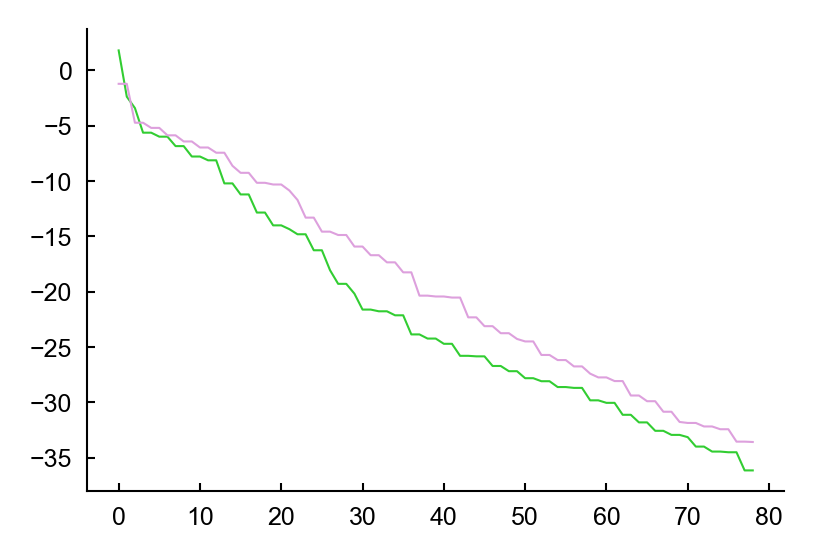

In [94]:
plt.plot(delase_a.stability_params[:int(top_percent*len(delase_a.stability_params))].cpu(), c='limegreen')
plt.plot(delase_u.stability_params[:int(top_percent*len(delase_u.stability_params))].cpu(), c='plum')
print(delase_a.stability_params[:int(top_percent*len(delase_a.stability_params))].cpu().mean())
print(delase_u.stability_params[:int(top_percent*len(delase_u.stability_params))].cpu().mean())